Initializing

In [5]:
#imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#retrieving data
path_data = '/Users/alvarochapela/Documents/DATOS_ZRIVE/Module2Data'

orders = pd.read_parquet(f"{path_data}/orders.parquet")
users = pd.read_parquet(f"{path_data}/users.parquet")
regulars = pd.read_parquet(f"{path_data}/regulars.parquet")
inventory = pd.read_parquet(f"{path_data}/inventory.parquet")
abandoned_carts = pd.read_parquet(f"{path_data}/abandoned_carts.parquet")


Starting the analysis

In [6]:
n_regulars = regulars.groupby('user_id')['variant_id'].nunique().reset_index().rename(columns={'variant_id':'n_regulars'})
users = users.merge(n_regulars, on='user_id', how = 'left').fillna({'n_regulars':0})
# Veo los users y quito nulls
users.dropna().head()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets,n_regulars
23,09d70e0b0778117aec5550c08032d56f8e06f992741680...,Proposition,UKI,2021-06-28 12:07:04,2021-06-01 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0
27,4f5ff38ce5ed48096ba80dff80e167db1ad24b9ebdb00c...,Top Up,UKD,2020-06-12 12:07:35,2020-06-01 00:00:00,3.0,2.0,0.0,1.0,0.0,1.0
28,7b2ae50bb11646436fa613394fc3e71e1a0cdc3ba30cdb...,Proposition,UKF,2020-10-03 09:53:57,2020-10-01 00:00:00,2.0,2.0,0.0,0.0,2.0,25.0
35,5e977a4aa2c57f306b8a22f92eaaa177f7dc31a52df82c...,Proposition,UKI,2021-10-14 10:41:13,2021-10-01 00:00:00,2.0,1.0,1.0,0.0,1.0,72.0
66,eafb89ad33eb377adb98a915b6a5a65f1284c2db517d07...,Proposition,UKH,2022-01-20 15:53:09,2022-01-01 00:00:00,2.0,2.0,0.0,0.0,0.0,3.0


Identificar tipos de compradores

In [37]:
frequent_shoppers = orders['user_id'].value_counts()
regular_shoppers = regulars['user_id']
cart_abandoners = abandoned_carts['user_id']
popular_products = orders['id'].explode().value_counts()

loyal_customers = regular_shoppers[regular_shoppers.isin(popular_products.index)]
cart_abandoners_not_regular = cart_abandoners[~cart_abandoners.isin(regular_shoppers)]

In [38]:
frequent_shoppers.describe()

count    4983.000000
mean        1.760586
std         1.936537
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        25.000000
Name: count, dtype: float64

<Axes: >

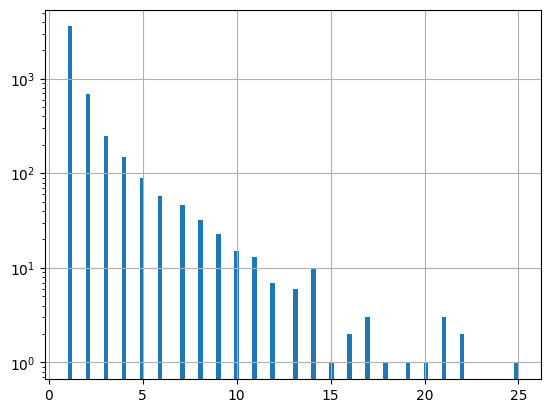

In [39]:
frequent_shoppers.hist(bins=100, log=True)

<Axes: >

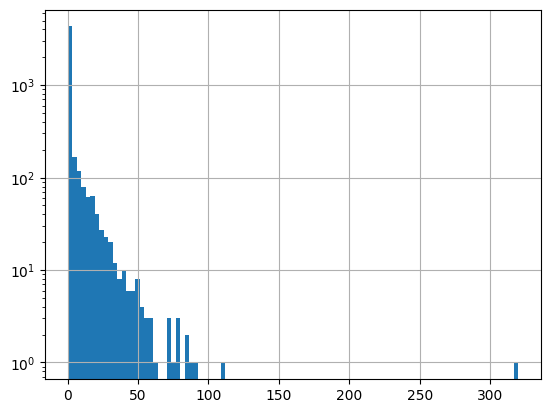

In [40]:
users['n_regulars'].hist(bins=100, log=True)

In [44]:
(users['n_regulars']>7).sum()/len(users)

0.09271523178807947

In [48]:
frequent_shoppers.info()


<class 'pandas.core.series.Series'>
Index: 4983 entries, ba7176c5f870cd86e51ecc4375e0becc8cc305845e70b9384ba0d4d156c6099ec96602b15420cb1ff69b6b9adcf9249d09489d511565531c4e928a92157b16d6 to bd5dd90b15fc4c382330a17915927322d928a091b13f91aabe1b58afb721b3d4f47c56ff306eb34e6d94cabeed4dcea7d6a15ed81d605a0e9f4fd05a4b787c55
Series name: count
Non-Null Count  Dtype
--------------  -----
4983 non-null   int64
dtypes: int64(1)
memory usage: 206.9+ KB


In [51]:
len(frequent_shoppers)/len(users)

1.0

Frequent shoppers no contiene lo que esperaba

In [53]:
family_cols = [col for col in users.columns if col.startswith('count_')]
family_inputs = users.count_people.dropna().count()

d = {f"any_{col}": (users[col] > 0).sum()/family_inputs for col in family_cols}
d

{'any_count_people': 0.9938461538461538,
 'any_count_adults': 0.9907692307692307,
 'any_count_children': 0.4,
 'any_count_babies': 0.07076923076923076,
 'any_count_pets': 0.40615384615384614}

In [54]:
#Casas con niños
(users[['count_children', 'count_babies']].sum(axis=1) > 0).sum() / family_inputs

0.4430769230769231

2. REGULAR PRODUCTS
